In [39]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from tqdm import tqdm
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

from utils import *

In [34]:
embedding_model = HuggingFaceEmbeddings(
    model_name="thenlper/gte-small",
    multi_process=True,
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True},
)

In [35]:
course_numbers = [
    1043, 1045, 1046, 1047, 1048, 1049, 1050, 1054, 1055, 1056, 
    1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 
    1067, 1068, 1069, 1221
]

courses = []
course_embeddings = []

for n in tqdm(course_numbers):
    new_course = Course(f'https://certification.adobe.com/courses/{n}')
    courses.append(new_course)
    # course_embeddings.append(new_course.get_embedding(embedding_model))

for c in courses:
    time_str = c.time.split()
    if len(time_str) == 2:
        c.cleaned_time = int(time_str[0])
    else:
        c.cleaned_time = int(time_str[0]) + (int(time_str[2]) / 60)

print(len(courses))

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:16<00:00,  1.48it/s]

24


In [36]:
certificate_htmls_location = 'certificate_htmls'
certificates = []
certificate_embeddings = []

for html in tqdm(os.listdir(certificate_htmls_location)):
    certificate = Certificate(f'{certificate_htmls_location}/{html}')
    certificates.append(certificate)
    # certificate_embeddings.append(certificate.get_embedding(embedding_model))

100%|██████████| 54/54 [00:22<00:00,  2.43it/s]


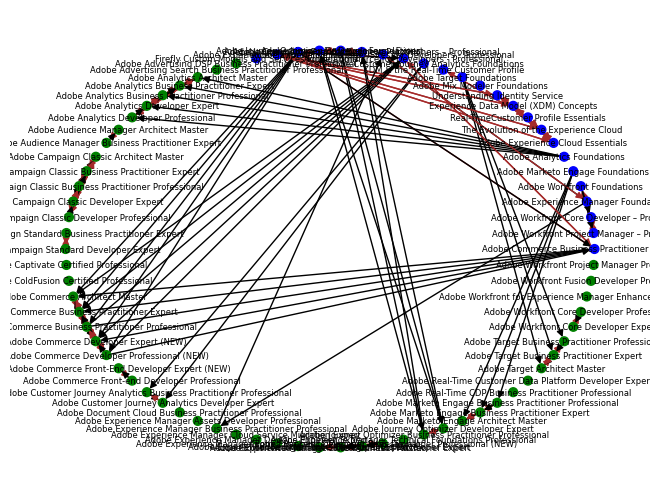

In [37]:
G = nx.DiGraph()

# similarity_matrix = cosine_similarity(all_embeddings)

sources = courses + certificates
node_colors = []
for src in sources:
    G.add_node(src)
    if type(src) == Course:
        node_colors.append('blue')
    else:
        node_colors.append('green')

levels = ['Foundations', 'Professional', 'Expert', 'Master']
threshold = 0.9

for i, src1 in enumerate(sources):
    for j, src2 in enumerate(sources):
        if i == j:
            continue
        if src1.is_prereq_to(src2):
            G.add_edge(src1, src2, color='black')
        elif src1.has_same(src2, 'category'):
            G.add_edge(src1, src2, color='brown')
        # elif src1.is_same_role_as(src2):
        #     G.add_edge(src1, src2, color='purple')
        
        # elif src1.category != src2.category and similarity_matrix[i, j] > threshold:
        #     G.add_edge(src1, src2, color='red')

colors = [G[u][v]['color'] for u,v in G.edges()]

pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_size=6, edge_color=colors, node_color=node_colors, node_size=40)

In [38]:
job_role_descriptions = {
    'Business Practitioner': '''Business Practitioners are responsible for designing, executing, and managing marketing campaigns using Adobe Experience Cloud solutions.
                            They should have a foundational understanding of Adobe’s digital marketing solutions, as well as experience in marketing and advertising.
                            The Business Practitioner certification validates their ability to effectively use Adobe’s digital marketing solutions to achieve business objectives.
                            ''',
    'Developer': '''Developers are responsible for implementing and integrating Adobe Experience Cloud solutions into an organization’s technology stack.
                    They should have experience in software development and proficiency in web technologies, such as HTML, CSS, JavaScript, and RESTful APIs.
                    The Developer certification validates their ability to effectively implement and customize Adobe’s digital marketing solutions to meet business requirements.
                ''',
    'Architect': '''Architects are responsible for designing and implementing enterprise-grade solutions using Adobe Experience Cloud solutions.
                    They should have extensive knowledge of Adobe’s digital marketing solutions and experience in software architecture, integration, and customization.
                    The Architect certification validates their ability to design and implement complex solutions using Adobe’s digital marketing solutions.
                '''
}

In [62]:
roles, documents = job_role_descriptions.keys(), job_role_descriptions.values()
doc_embeddings = embedding_model.embed_documents(documents)

In [75]:
job_role_query = "I want to primarily work with digital marketing, such as advertising."
query_embeddings = embedding_model.embed_documents([job_role_query])

In [76]:
scores = cosine_similarity(query_embeddings, doc_embeddings)

list(zip(roles, scores[0]))

[('Business Practitioner', 0.8445339830180175),
 ('Developer', 0.8152267255418365),
 ('Architect', 0.8155065885611044)]

In [88]:
starting_node = {
    'category': 'Adobe Commerce',
    'level': 'Foundations',
    'type': Course
}

job_role_query = "I want to primarily work with digital marketing, such as advertising."

In [100]:
from collections import deque

def get_specific_graph(relevant_roles, info_level, starting_node):
    G = nx.DiGraph()
    queue = deque()
    sources = [i for i in courses + certificates if i.job_role in relevant_roles]

    # first, we find the root node(s)

    for src in sources:
        if src.category == starting_node['category'] and src.level == starting_node['level'] and type(src) == starting_node['type']:
            queue.append(src)
            G.add_node(src)

    # now that we have the root node, we find children up to the user-specified level

    if info_level == 'low':
        pass

    if info_level == 'medium':
        certificate_in_graph = False
        while queue and not certificate_in_graph:
            node = queue.popleft()

            for i, src in enumerate(sources):
                if node.is_prereq_to(src):
                    if src not in G:
                        G.add_node(src)
                        queue.append(src)
                        if type(src) == Certificate:
                            certificate_in_graph = True
                    G.add_edge(node, src)

    if info_level == 'high':
        while queue:
            node = queue.popleft()

            for i, src in enumerate(sources):
                if node.is_prereq_to(src):
                    if src not in G:
                        G.add_node(src)
                        queue.append(src)
                    G.add_edge(node, src)


    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, font_size=6, node_size=40)
    return G

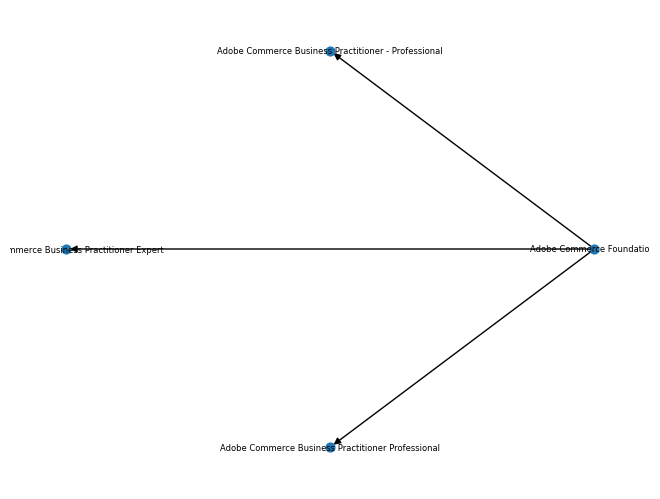

In [101]:
get_specific_graph(['All', 'Business Practitioner'], 'medium', starting_node=starting_node)